In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

In [15]:
PATH = '/Users/kaiwentay/Documents/GitHub/Pair_Trading_Fun/Data/minute_data.csv'
df = pd.read_csv(PATH, index_col = 0, parse_dates = True)

In [29]:
df

,stock_X,stock_Y,spread
timestamp,,,
2023-08-01 12:03:00+00:00,27.745,533.71,336.1656
2023-08-01 12:04:00+00:00,27.750,533.71,336.1300
2023-08-01 12:05:00+00:00,27.760,533.71,336.0588
2023-08-01 12:06:00+00:00,27.775,533.71,335.9520
2023-08-01 12:07:00+00:00,27.740,533.71,336.2012
...,...,...,...
2023-11-01 23:55:00+00:00,16.270,455.50,339.6576
2023-11-01 23:56:00+00:00,16.290,455.50,339.5152
2023-11-01 23:57:00+00:00,16.300,455.50,339.4440


<AxesSubplot: xlabel='timestamp'>

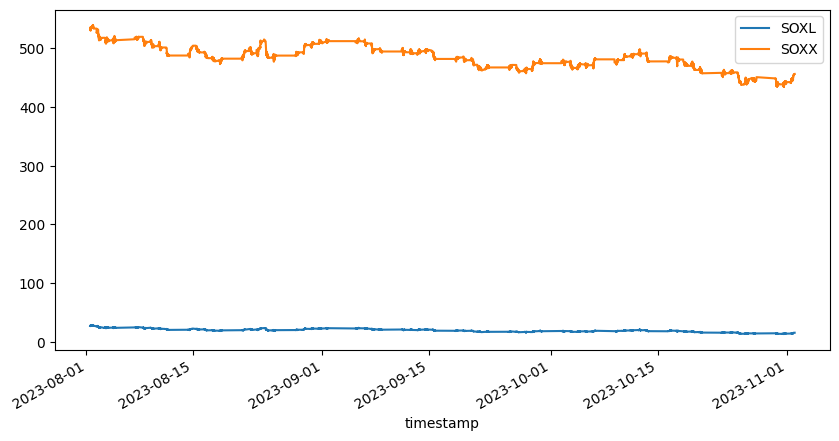

In [16]:
df.plot(figsize = (10,5))

# Pair Trading
In steps, we will do the backtest for a single pair at first.
1. Regress X against Y (order doesn't really matter here)
2. Take the spread between the two
3. Check stationarity using ADF
4. Adjust and test various values of $\beta$ to get the best ADF results
5. Use our test values to trade

<AxesSubplot: xlabel='timestamp'>

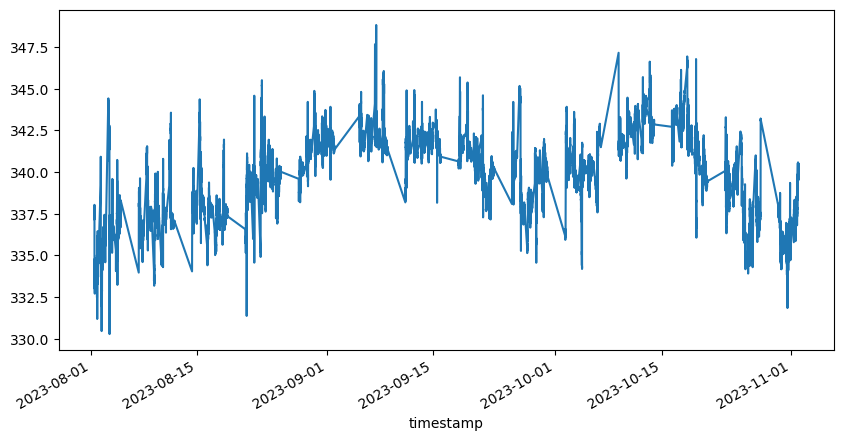

In [17]:
#regressing X against Y
def regression(df):
    """df is a dataframe with 2 columns"""
    X = df.iloc[:,0]
    Y = df.iloc[:,1]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    return model.params[1]

beta = regression(df)

#calculating spread
def calculate_spread(df, beta):
    """df is a dataframe with 2 columns"""
    X = df.iloc[:,0]
    Y = df.iloc[:,1]
    return Y - beta*X

spread = calculate_spread(df, beta)
spread.plot(figsize = (10,5))

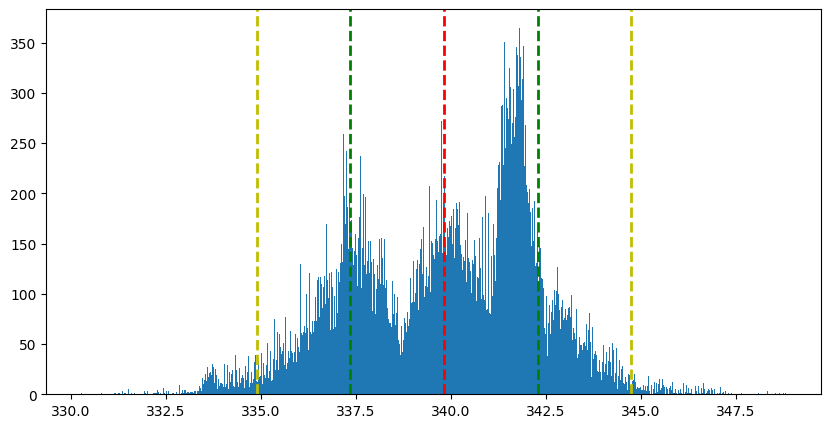

7.076878610073345


In [21]:
#histogram of spread
plt.figure(figsize=(10,5))
plt.hist(spread, bins=1000)
mean = spread.mean()
std = spread.std()
two_std = 2*std
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)
plt.axvline(mean+std, color='g', linestyle='dashed', linewidth=2)
plt.axvline(mean-std, color='g', linestyle='dashed', linewidth=2)
plt.axvline(mean+two_std, color='y', linestyle='dashed', linewidth=2)
plt.axvline(mean-two_std, color='y', linestyle='dashed', linewidth=2)
plt.show()
print(beta)

In [19]:
# Checking for stationarity using ADF test
adf = sm.tsa.stattools.adfuller(spread, maxlag = 1)
print('ADF Statistic: %f' % adf[0])

ADF Statistic: -11.536597


In [20]:
# Initialize DataFrame to store results
results = pd.DataFrame(columns=['Beta', 'ADF Statistic'])

# Iterate over beta values
for i in tqdm(np.arange(0, 10, 0.01)):
    spread_series = calculate_spread(df, i)
    adf_stat = sm.tsa.stattools.adfuller(spread_series, maxlag=1)[0]
    results = results.append({'Beta': i, 'ADF Statistic': adf_stat}, ignore_index=True)

100%|██████████| 1000/1000 [00:34<00:00, 28.86it/s]


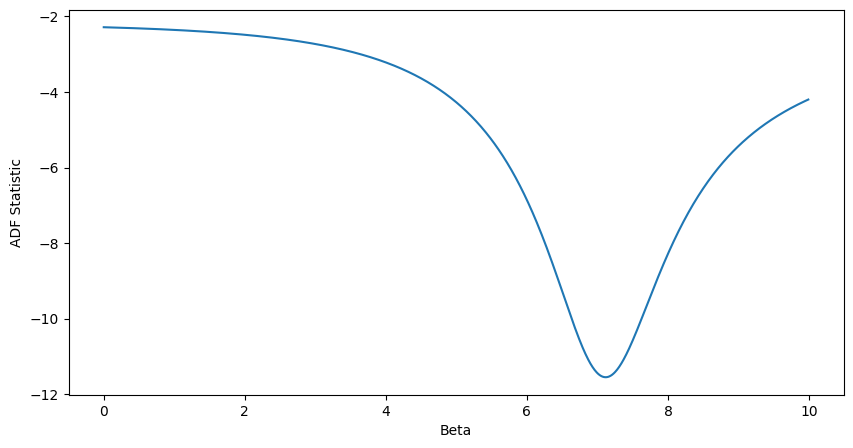

min ADF Statistic & Beta:  -11.549057541235552 ( 7.12 )
max ADF Statistic & Beta:  -2.2852362739693493 ( 0.0 )


In [101]:
plt.figure(figsize=(10,5))
plt.plot(results['Beta'], results['ADF Statistic'])
plt.xlabel('Beta')
plt.ylabel('ADF Statistic')
plt.show()
print("min ADF Statistic & Beta: ", results['ADF Statistic'].min(), "(",results['Beta'][results['ADF Statistic'].idxmin()], ")")
print("max ADF Statistic & Beta: ", results['ADF Statistic'].max(), "(",results['Beta'][results['ADF Statistic'].idxmax()], ")")

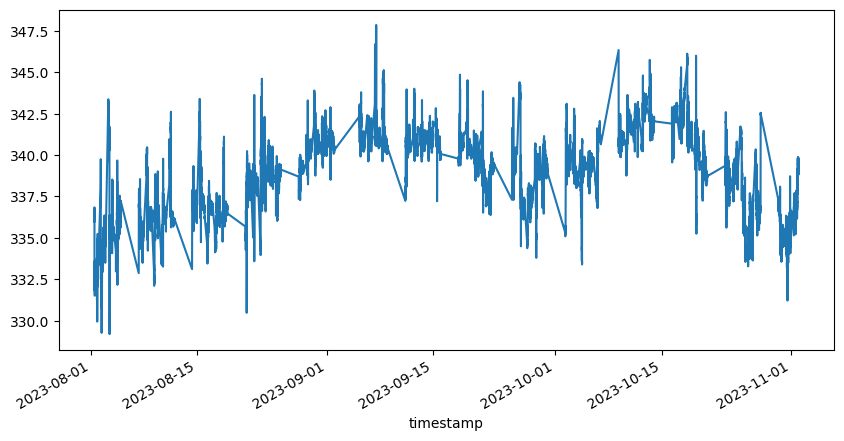

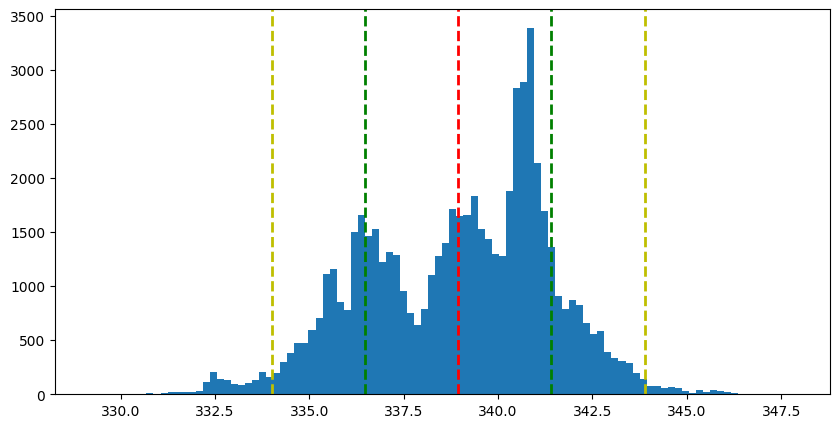

In [23]:
#replot spread with optimal beta
beta = results['Beta'][results['ADF Statistic'].idxmin()]
spread = calculate_spread(df, beta)
spread.plot(figsize = (10,5))

#histogram of spread
plt.figure(figsize=(10,5))
plt.hist(spread, bins=100)
mean = spread.mean()
std = spread.std()
two_std = 2*std
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)
plt.axvline(mean+std, color='g', linestyle='dashed', linewidth=2)
plt.axvline(mean-std, color='g', linestyle='dashed', linewidth=2)
plt.axvline(mean+two_std, color='y', linestyle='dashed', linewidth=2)
plt.axvline(mean-two_std, color='y', linestyle='dashed', linewidth=2)
plt.show()

Selecting a beta of 7.12 allows us to maintain the highest stationarity statistics for these stocks.

# Backtesting The Strat
We will take each value of the minute observations and pair trade whenever the spread is more than 2 standard deviations beyond the mean.

Specifically, we will:
- Long X and short Y when spread becomes too large and close the position when it reverts to the mean
- Short X and long Y when spread becomes too small and close the position when it reverts to the mean

Note that X is always scaled to our beta value. 

We will refrain from opening too many positions in the meantime, and maintain just one position that we have to close off whenever we trade (e.g. day 1 we open long beta units of X and short Y, we observe this position and wait for it to revert to the mean to close out before we open any other positions)

In [98]:
#backtesting our pair trading strategy with optimal beta
# 1. Build out a trading strategy (if spread > mean + 2*std, short spread, if spread < mean - 2*std, long spread). Once spread returns to mean, close position.
# 2. Calculate PnL
# 3. Calculate Sharpe Ratio

wealth = 100000
# 1. Build out a trading strategy
# 1.1. Create a function that stores positions starting with some wealth amount (we execute trades such that our wealth is always > x% of our previous wealth). Run it on our dataframe
def trading_strategy(df, wealth, beta, multiplier):
    df = df.iloc[:,[0,1]]
    df.columns = ['stock_X', 'stock_Y']
    
    # Step 1: Calculate the spread
    df['spread'] = df['stock_Y'] - beta * df['stock_X']

    # Calculate mean and standard deviation of the spread
    mean_spread = df['spread'].mean()
    std_spread = df['spread'].std()

    # Initialize variables
    position = None  # 'long', 'short', or None
    entry_price = None  # Entry price
    max_portfolio_value = wealth * 0.5  # Maximum amount to be used for trading

    # trading data frame
    orderbook = pd.DataFrame(columns=['Date', 'Order', 'Price', 'units of X', 'units of Y', 'price of X', 'Price of Y', 'PNL','Wealth'])
    wealth_time_series = pd.DataFrame(columns=['Date', 'Wealth'])

    # Iterate over the dataframe
    for index, row in df.iterrows():
        current_spread = row['spread']
        stock_X_price = row['stock_X']
        stock_Y_price = row['stock_Y']

        if position is None:
            # number of units must be less than max_portfolio_value (i.e. we optimise for a rounded figure of long cost - short proceeds < max_portfolio_value)
            units = int(max_portfolio_value / abs(stock_Y_price - beta * stock_X_price))
            if current_spread > mean_spread + multiplier * std_spread:
                # Short spread
                position = 'short'
                entry_price = current_spread
                orderbook = orderbook.append({'Date': index, 'Order': 'short', 'Price': current_spread, 'units of X': beta * units, 'units of Y': -units, 'price of X': stock_X_price, 'Price of Y': stock_Y_price, 'PNL': 0, 'Wealth': wealth}, ignore_index=True)
                wealth_time_series = wealth_time_series.append({'Date': index, 'Wealth': wealth}, ignore_index=True)
            elif current_spread < mean_spread - multiplier * std_spread:
                # Long spread
                position = 'long'
                entry_price = current_spread
                orderbook = orderbook.append({'Date': index, 'Order': 'long', 'Price': current_spread, 'units of X': -beta * units, 'units of Y': units, 'price of X': stock_X_price, 'Price of Y': stock_Y_price, 'PNL': 0, 'Wealth': wealth}, ignore_index=True)
                wealth_time_series = wealth_time_series.append({'Date': index, 'Wealth': wealth}, ignore_index=True)
        else:
            # Check for exit signal
            if (position == 'short' and current_spread <= mean_spread):
                # Close position
                exit_price = current_spread
                pnl = (entry_price - exit_price) * units
                wealth += pnl
                orderbook = orderbook.append({'Date': index, 'Order': 'close', 'Price': current_spread, 'units of X': -beta * units, 'units of Y': units, 'price of X': stock_X_price, 'Price of Y': stock_Y_price, 'PNL': pnl, 'Wealth': wealth}, ignore_index=True)
                position = None
                entry_price = None
            elif (position == 'long' and current_spread >= mean_spread):
                # Close position
                exit_price = current_spread
                pnl = (exit_price - entry_price) * units
                wealth += pnl
                orderbook = orderbook.append({'Date': index, 'Order': 'close', 'Price': current_spread, 'units of X': -beta * units, 'units of Y': units, 'price of X': stock_X_price, 'Price of Y': stock_Y_price, 'PNL': pnl, 'Wealth': wealth}, ignore_index=True)
                position = None
                entry_price = None
            else:
                # Hold position and calculate PnL for the existing position
                if position == 'short':
                    # For a short position, profit is made if the spread increases
                    mtm_pnl = (current_spread - entry_price) * units
                elif position == 'long':
                    # For a long position, profit is made if the spread decreases
                    mtm_pnl = (entry_price - current_spread) * units

                # Update wealth based on MtM PnL
                current_wealth = wealth + mtm_pnl
                wealth_time_series = wealth_time_series.append({'Date': index, 'Wealth': current_wealth}, ignore_index=True)
    
    return wealth_time_series, orderbook, mean_spread, std_spread

def performance_summary(return_data, annualization = 12):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*annualization)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(annualization))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']

    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [99]:
#backtesting our pair trading strategy with optimal beta
wealth_time_series, orderbook, meanspread, std_spread = trading_strategy(df, wealth, 7, 0.5)

In [100]:
meanspread, std_spread

(341.38278004873126, 2.4724391810179016)

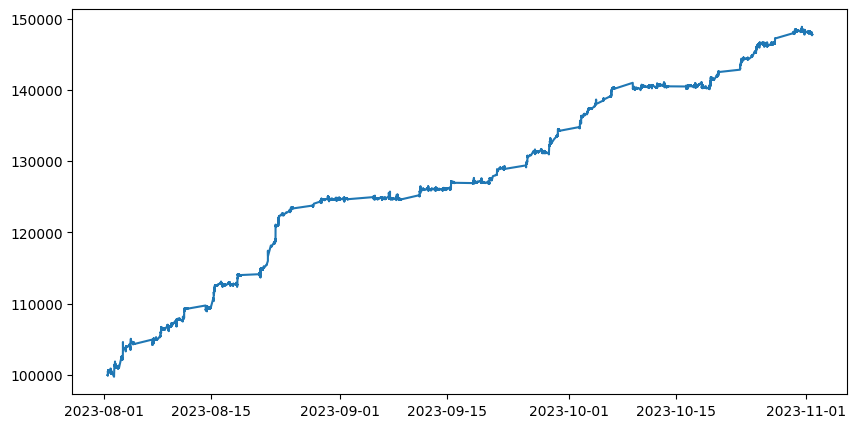

In [93]:
# set index
wealth_time_series.set_index('Date', inplace=True)
orderbook.set_index('Date', inplace=True)

# plot wealth time series
plt.figure(figsize=(10,5))
plt.plot(wealth_time_series['Wealth'])

plt.show()

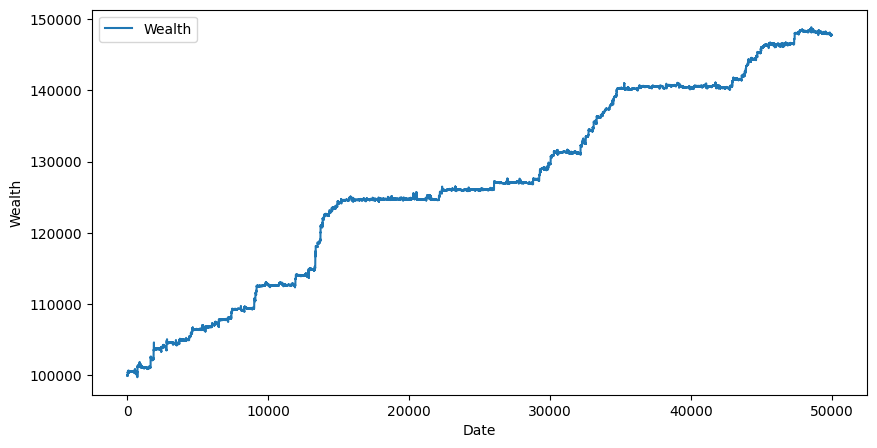

In [102]:
plt.figure(figsize=(10,5))
plt.plot(wealth_time_series['Wealth'])
plt.legend(['Wealth'])
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.show()

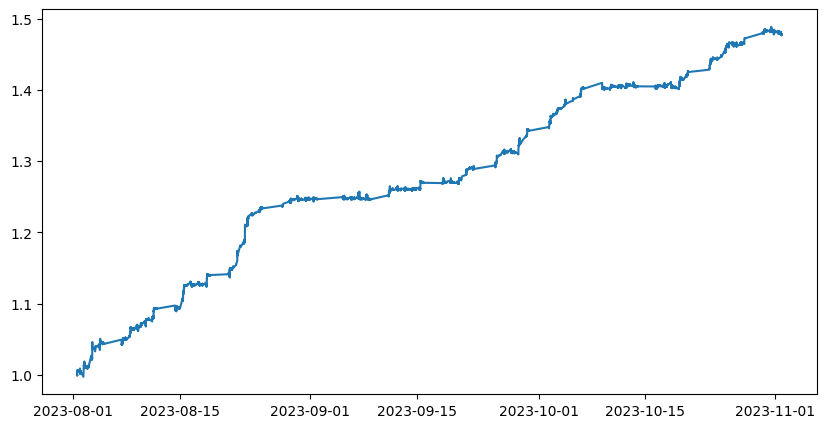

In [94]:
# calculate returns from wealth time series
wealth_time_series['Returns'] = wealth_time_series['Wealth'].pct_change()
wealth_time_series['Returns'].fillna(0, inplace=True)
wealth_time_series['cum_returns'] = (wealth_time_series['Returns'] + 1).cumprod()
wealth_time_series['cum_returns'].fillna(1, inplace=True)

# plot cumulative returns
plt.figure(figsize=(10,5))
plt.plot(wealth_time_series['cum_returns'])
plt.show()

In [95]:
wealth_time_series

,Wealth,Returns,cum_returns
Date,,,
2023-08-01 12:03:00+00:00,100000,0.000000,1.000000
2023-08-01 12:04:00+00:00,100005.145,0.000051,1.000051
2023-08-01 12:05:00+00:00,100015.435,0.000103,1.000154
2023-08-01 12:06:00+00:00,100030.87,0.000154,1.000309
2023-08-01 12:07:00+00:00,99994.855,-0.000360,0.999949
...,...,...,...
2023-11-01 20:37:00+00:00,147837.7912,0.000000,1.478378
2023-11-01 20:38:00+00:00,147858.3712,0.000139,1.478584
2023-11-01 20:39:00+00:00,147848.0812,-0.000070,1.478481


In [96]:
performance_summary(wealth_time_series[['Returns']], annualization = 98280)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
Returns,0.774798,0.111882,6.925122,9.08049,323.060212,-0.000286,-0.000542,-0.012603,2023-08-03 12:02:00+00:00,2023-08-03 20:45:00+00:00,2023-08-04 12:30:00+00:00


In [97]:
orderbook

,Order,Price,units of X,units of Y,price of X,Price of Y,PNL,Wealth
Date,,,,,,,,
2023-08-01 12:03:00+00:00,long,339.495,-1029,147,27.745,533.71,0,100000
2023-08-02 08:02:00+00:00,close,341.880,-1029,147,27.220,532.42,350.595,100350.595
2023-08-02 08:19:00+00:00,short,343.000,1015,-145,27.060,532.42,0,100350.595
2023-08-02 08:24:00+00:00,close,336.915,-1015,145,27.055,526.30,882.325,101232.92
2023-08-02 08:25:00+00:00,long,336.940,-1036,148,27.080,526.50,0,101232.92
...,...,...,...,...,...,...,...,...
2023-10-27 23:17:00+00:00,close,344.080,-1029,147,15.130,449.99,767.34,147232.1212
2023-10-27 23:18:00+00:00,short,344.220,1015,-145,15.110,449.99,0,147232.1212
2023-10-30 08:00:00+00:00,close,339.090,-1015,145,15.530,447.80,743.85,147975.9712
